In [1]:
# Check the GPU
!nvidia-smi

Fri Jun  7 10:40:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Install dependencies.
!pip install bitsandbytes transformers accelerate peft -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 66.6 MB/s eta 0:00:00


In [3]:
# Installing diffusers from main
!pip install git+https://github.com/huggingface/diffusers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
# Downloading diffusers SDXL DreamBooth training script
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2024-06-07 10:42:17--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84311 (82K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  82.33K  --.-KB/s    in 0.002s  

2024-06-07 10:42:18 (46.0 MB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [84311/84311]



In [5]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [6]:
!unzip /content/me.zip
!unzip /content/prior.zip

Archive:  /content/me.zip
  inflating: me/above.JPG            
  inflating: me/below.JPG            
  inflating: me/bottom_left.JPG      
  inflating: me/bottom_right.JPG     
  inflating: me/front.jpg            
  inflating: me/left.JPG             
  inflating: me/right.JPG            
Archive:  /content/prior.zip
  inflating: results/result_174.jpg  
  inflating: results/result_167.jpg  
  inflating: results/result_195.jpg  
  inflating: results/result_178.jpg  
  inflating: results/result_190.jpg  
  inflating: results/result_197.jpg  
  inflating: results/result_176.jpg  
  inflating: results/result_185.jpg  
  inflating: results/result_183.jpg  
  inflating: results/result_186.jpg  
  inflating: results/result_166.jpg  
  inflating: results/result_160.jpg  
  inflating: results/result_181.jpg  
  inflating: results/result_169.jpg  
  inflating: results/result_187.jpg  
  inflating: results/result_191.jpg  
  inflating: results/result_172.jpg  
  inflating: results/result_180.j

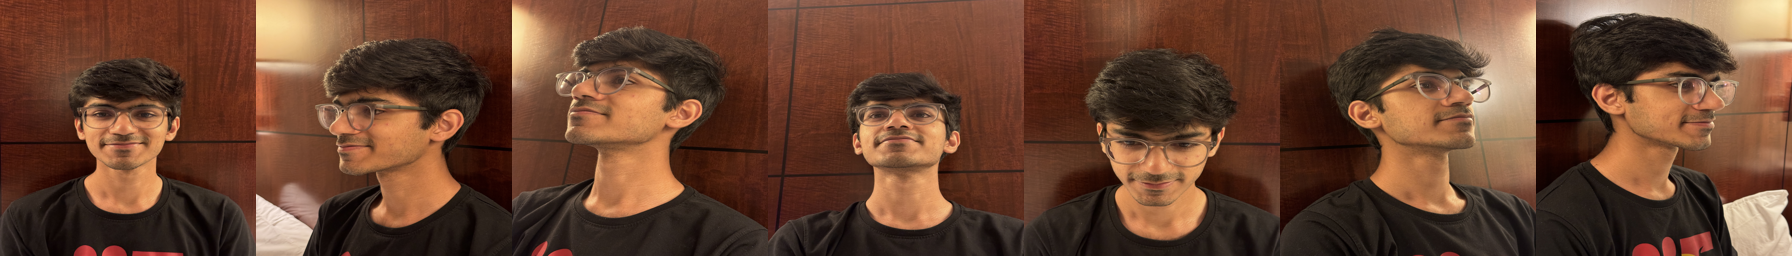

In [7]:
import glob

# change path to display images from your local dir
img_paths = "./me/*.JPG"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 7
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

Training

In [8]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [9]:
from huggingface_hub import notebook_login
notebook_login()

Without Prior Reservation

In [10]:
import shutil
import os

# Path to the .ipynb_checkpoints directory
checkpoints_dir = "/content/me/.ipynb_checkpoints"

# Check if the directory exists and remove it
if os.path.exists(checkpoints_dir) and os.path.isdir(checkpoints_dir):
    shutil.rmtree(checkpoints_dir)
    print(f"Deleted directory: {checkpoints_dir}")
else:
    print(f"Directory not found: {checkpoints_dir}")

Deleted directory: /content/me/.ipynb_checkpoints


In [ ]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --instance_data_dir="me" \
  --output_dir="sdxl-satvik-without-prior" \
  --mixed_precision="fp16" \
  --instance_prompt="A photo of Satvik person" \
  --resolution=1024 \
  --train_batch_size=2 \
  --gradient_accumulation_steps=2 \
  --gradient_checkpointing \
  --learning_rate=6e-5 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --use_8bit_adam \
  --max_train_steps=1000

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
2024-06-07 07:21:20.005520: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 07:21:20.005570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 07:21:20.007228: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] 

With Prior Reservation

In [11]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --instance_data_dir="me" \
  --class_data_dir="results" \
  --output_dir="sdxl-satvik-with-prior" \
  --mixed_precision="fp16" \
  --instance_prompt="A photo of Satvik person" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=2 \
  --gradient_checkpointing \
  --learning_rate=6e-5 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --use_8bit_adam \
  --max_train_steps=1000\
  --with_prior_preservation --prior_loss_weight=1.0\
  --class_prompt="A photo of a person"\
  --num_class_images=197

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
2024-06-07 10:44:52.161181: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 10:44:52.161234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 10:44:52.304895: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] 